In [1]:
import gc

import matplotlib.pyplot as plt
import numpy as np
import torch
from sae_lens import SAE, ActivationsStore
from tqdm.autonotebook import tqdm
from transformer_lens import HookedTransformer

from sae_cooccurrence.normalised_cooc_functions import (
    apply_activation_threshold,
    get_feature_activations_for_batch,
    get_sae_threshold,
    get_special_tokens,
)
from sae_cooccurrence.utils.saving_loading import (
    set_device,
)

In [2]:
# set seed
np.random.seed(42)

# Profile activation density

In [3]:
def plot_max_activations(
    sae_ids,
    model_name,
    sae_release_short,
    n_batches=100,
    n_bins=100,
    activation_threshold=0.5,
    observation_threshold=10,
    n_batches_in_buffer=32,
    normalise_internal_threshold=True,
    remove_special_tokens=True,
    apply_internal_activation_threshold=False,
):
    """
    Analyze and plot maximum activations for Sparse Autoencoders (SAEs) across multiple batches.

    This function processes a list of SAE IDs for a given model and SAE release, generating
    activation histograms and feature observation plots. It displays the results as plots
    without saving them.

    Parameters:
    - sae_ids (list): List of SAE identifiers to process.
    - model_name (str): Name of the transformer model (e.g., "gpt2-small", "gemma-2-2b").
    - sae_release_short (str): Short name for the SAE release (e.g., "res-jb", "gemma-scope-2b-pt-res-canonical").
    - n_batches (int): Number of batches to process for each SAE (default: 100).
    - n_bins (int): Number of bins for the activation histograms (default: 100).
    - activation_threshold (float): Threshold for considering a feature as activated (default: 0.5).
    - observation_threshold (int): Minimum number of times a feature must be observed to be counted (default: 10).
    - n_batches_in_buffer (int): Number of batches to keep in the activation store buffer (default: 32).
    - normalise_internal_threshold (bool): Whether to normalize activations by subtracting the SAE threshold (default: True).
    - apply_internal_activation_threshold (bool): Whether to apply the SAE's internal activation threshold (default: False) cannot be used if normalise_internal_threshold is also True.

    The function performs the following steps for each SAE:
    1. Loads the SAE and sets up an activation store.
    2. Processes batches of activations, tracking maximum activations and feature observations.
    3. Generates three plots:
       a. Full histogram of maximum feature activations.
       b. Zoomed histogram focusing on the lower range of activations.
       c. Plot showing the fraction of features observed above the threshold over batches.
    4. Displays the plots.

    Note:
    This function requires several imported modules and utility functions, including
    matplotlib, numpy, torch, and custom modules for SAE and transformer operations.
    """
    torch.set_grad_enabled(False)
    device = set_device()

    model = HookedTransformer.from_pretrained(model_name, device=device)

    special_tokens = get_special_tokens(model)

    for sae_id in tqdm(sae_ids, desc=f"Processing SAEs for {sae_release_short}"):
        if model_name == "gemma-2-2b":
            release = "gemma-scope-2b-pt-res-canonical"
        else:
            release = f"{model_name}-{sae_release_short}"

        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release=release, sae_id=sae_id, device=device
        )

        sae.W_dec.norm(dim=-1).mean()
        sae.fold_W_dec_norm()

        sae_threshold = get_sae_threshold(sae, device)

        activation_store = ActivationsStore.from_sae(
            model=model,
            sae=sae,
            streaming=True,
            store_batch_size_prompts=8,
            train_batch_size_tokens=4096,
            n_batches_in_buffer=n_batches_in_buffer,
            device=device,
        )

        all_max_activations = []
        total_features = sae.cfg.d_sae
        feature_observations = torch.zeros(
            total_features, dtype=torch.int, device=device
        )  # Move to the same device
        fraction_features_observed = []
        batch_numbers = []

        for batch_num in tqdm(
            range(n_batches), desc=f"Processing batches for {sae_id}"
        ):
            activations_batch = get_feature_activations_for_batch(
                activation_store, device, remove_special_tokens, special_tokens
            )
            feature_acts = sae.encode(activations_batch).squeeze()
            if normalise_internal_threshold and not apply_internal_activation_threshold:
                feature_acts = feature_acts - sae_threshold
            elif (
                apply_internal_activation_threshold and not normalise_internal_threshold
            ):
                feature_acts = apply_activation_threshold(
                    feature_acts, activation_threshold, sae_threshold
                )
            elif apply_internal_activation_threshold and normalise_internal_threshold:
                raise ValueError(
                    "Cannot apply both internal activation threshold and normalise internal threshold"
                )
            max_activations = torch.max(feature_acts, dim=0).values
            all_max_activations.append(max_activations.cpu().numpy())

            # Count features observed above the threshold
            if normalise_internal_threshold and not apply_internal_activation_threshold:
                observed_features = (feature_acts > activation_threshold).any(dim=0)
            elif (
                apply_internal_activation_threshold and not normalise_internal_threshold
            ):
                observed_features = apply_activation_threshold(
                    feature_acts, activation_threshold, sae_threshold
                ).any(dim=0)
            elif apply_internal_activation_threshold and normalise_internal_threshold:
                raise ValueError(
                    "Cannot apply both internal activation threshold and normalise internal threshold"
                )
            else:
                observed_features = (feature_acts > activation_threshold).any(dim=0)
            feature_observations += observed_features

            # Calculate fraction of features observed more than observation_threshold times
            features_observed_enough = (
                (feature_observations > observation_threshold).sum().item()
            )
            fraction_observed = features_observed_enough / total_features
            fraction_features_observed.append(fraction_observed)
            batch_numbers.append(batch_num + 1)

        all_max_activations = np.concatenate(all_max_activations)

        # Create a new figure with three subplots for each SAE size
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 14.4))

        # sae_size = (
        #     sae_id.split(".")[-1]
        #     if sae_release_short == "res-jb"
        #     else sae_id.split("_")[-1]
        # )

        # Full histogram
        counts, bins, _ = ax1.hist(all_max_activations, bins=n_bins, edgecolor="black")
        ax1.set_title(
            f"Histogram of Maximum Feature Activations\nModel: {model_name}, SAE Release: {sae_release_short}, SAE ID: {sae_id}"
        )
        ax1.set_xlabel("Maximum Activation Value")
        ax1.set_ylabel("Count")
        ax1.set_yscale("log")
        ax1.grid(True, which="both", ls="-", alpha=0.2)

        # Find the first bin with zero entries
        non_zero_bins = np.where(counts == 0)[0]
        if len(non_zero_bins) > 0:
            zoom_limit = bins[non_zero_bins[0]]
        else:
            zoom_limit = bins[-1]

        # Zoomed histogram
        ax2.hist(
            all_max_activations, bins=n_bins, range=(0, zoom_limit), edgecolor="black"
        )
        ax2.set_title("Zoomed Histogram (0 to first zero-count bin)")
        ax2.set_xlabel("Maximum Activation Value")
        ax2.set_ylabel("Count")
        ax2.set_yscale("log")
        ax2.grid(True, which="both", ls="-", alpha=0.2)

        # Fraction of features observed more than threshold times over batches
        ax3.plot(batch_numbers, fraction_features_observed, marker="o")
        ax3.set_title(
            f"Fraction of Features Observed > {observation_threshold} Times vs. Number of Batches\n(Activation Threshold: {activation_threshold})"
        )
        ax3.set_xlabel("Number of Batches")
        ax3.set_ylabel(f"Fraction of Features Observed > {observation_threshold} Times")
        ax3.set_ylim(0, 1)
        ax3.grid(True, which="both", ls="-", alpha=0.2)

        # Add horizontal line at 90%
        ax3.axhline(y=0.9, color="r", linestyle="--", label="90% threshold")
        ax3.legend()

        plt.tight_layout()
        plt.show()  # Display the plot instead of saving

        # Empty CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Perform garbage collection
        gc.collect()

        print("PyTorch memory cleared.")

In [4]:
# Configuration
model_name_gpt2small = "gpt2-small"

gpt2_batches = 32

# Configuration for res-jb-feature-splitting
sae_release_short_fs = "res-jb-feature-splitting"
sae_ids_fs = [
    # "blocks.8.hook_resid_pre_768",
    # "blocks.8.hook_resid_pre_1536",
    # "blocks.8.hook_resid_pre_3072",
    # "blocks.8.hook_resid_pre_6144",
    # "blocks.8.hook_resid_pre_12288",
    "blocks.8.hook_resid_pre_24576",
]

In [5]:
# Configuration for res-jb
sae_release_short_rj = "res-jb"
sae_ids_rj = [
    "blocks.0.hook_resid_pre",
    # "blocks.7.hook_resid_pre",
    # "blocks.11.hook_resid_pre",
]

In [6]:
model_name_gemma22b = "gemma-2-2b"

sae_release_short_gemma22b = "gemma-scope-2b-pt-res-canonical"

gemma_batches = 4

sae_ids_gemma22b = [
    # "layer_0/width_16k/canonical",
    # "layer_12/width_16k/canonical",
    # "layer_18/width_16k/canonical",
    "layer_21/width_16k/canonical",
    # "layer_25/width_16k/canonical"
]

normalise_internal_threshold = True

Using MPS
Loaded pretrained model gpt2-small into HookedTransformer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Processing SAEs for res-jb-feature-splitting:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sae_lens/sae.py:136: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sae_lens/training/activations_store.py:245: UserWarning: Dataset is not tokenized. Pre-tokenizing will improve performance and allows for more control over special tokens. See https://jbloomaus.git

Processing batches for blocks.8.hook_resid_pre_24576:   0%|          | 0/40 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1217 > 1024). Running this sequence through the model will result in indexing errors


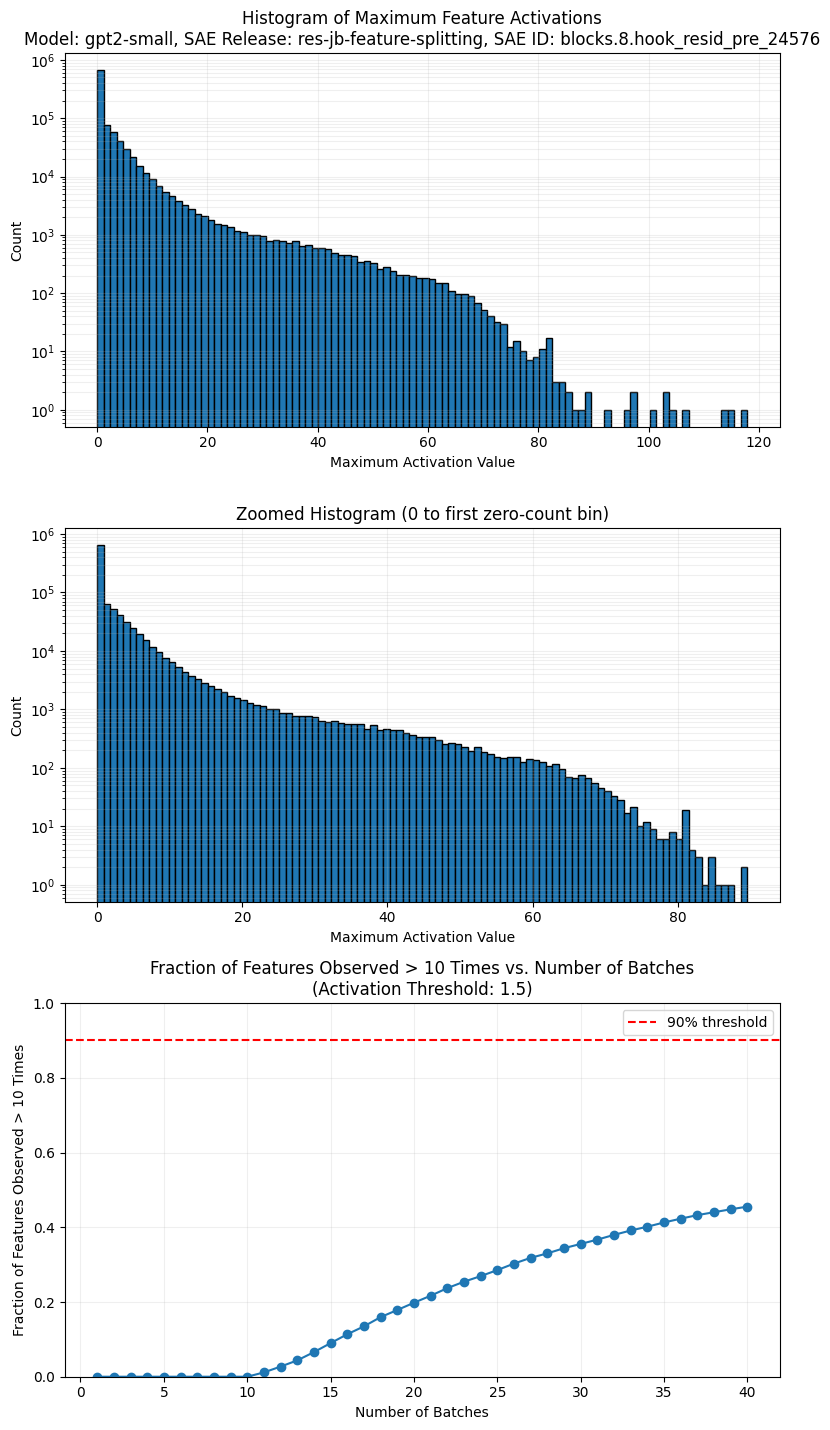

In [7]:
plot_max_activations(
    sae_ids_fs,
    model_name_gpt2small,
    sae_release_short_fs,
    n_batches=40,
    n_bins=100,
    activation_threshold=1.5,
    observation_threshold=10,
    n_batches_in_buffer=gpt2_batches,
    normalise_internal_threshold=normalise_internal_threshold,
    apply_internal_activation_threshold=False,
)

Using MPS
Loaded pretrained model gpt2-small into HookedTransformer


Processing SAEs for res-jb:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sae_lens/sae.py:136: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Processing batches for blocks.0.hook_resid_pre:   0%|          | 0/40 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1217 > 1024). Running this sequence through the model will result in indexing errors


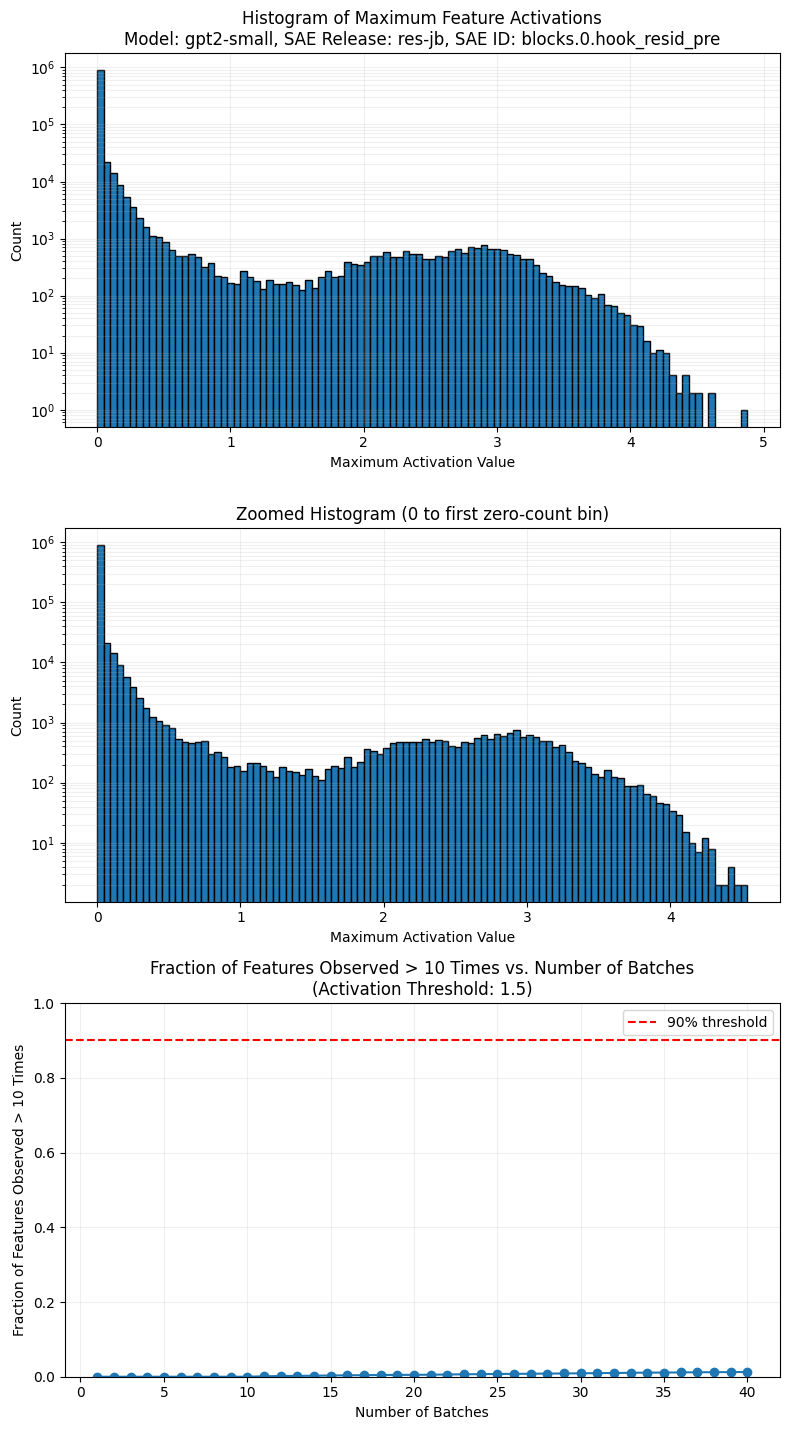

In [8]:
plot_max_activations(
    sae_ids_rj,
    model_name_gpt2small,
    sae_release_short_rj,
    n_batches=100,
    n_bins=100,
    activation_threshold=1.5,
    observation_threshold=10,
    n_batches_in_buffer=gpt2_batches,
    normalise_internal_threshold=normalise_internal_threshold,
    apply_internal_activation_threshold=False,
)

In [9]:
plot_max_activations(
    sae_ids_gemma22b,
    model_name_gemma22b,
    sae_release_short_gemma22b,
    n_batches=40,
    n_bins=100,
    activation_threshold=1.5,
    observation_threshold=10,
    n_batches_in_buffer=gemma_batches,
    remove_special_tokens=False,
    normalise_internal_threshold=False,
    apply_internal_activation_threshold=False,
)

Using MPS


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


Processing SAEs for gemma-scope-2b-pt-res-canonical:   0%|          | 0/1 [00:00<?, ?it/s]

params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Processing batches for layer_21/width_16k/canonical:   0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

Using GPU 0 out of 1 available GPUs


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


Processing SAEs for gemma-scope-2b-pt-res-canonical:   0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sae_lens/training/activations_store.py:246: UserWarning: Dataset is not tokenized. Pre-tokenizing will improve performance and allows for more control over special tokens. See https://jbloomaus.github.io/SAELens/training_saes/#pretokenizing-datasets for more info.
  warnings.warn(


Processing batches for layer_21/width_16k/canonical:   0%|          | 0/40 [00:00<?, ?it/s]

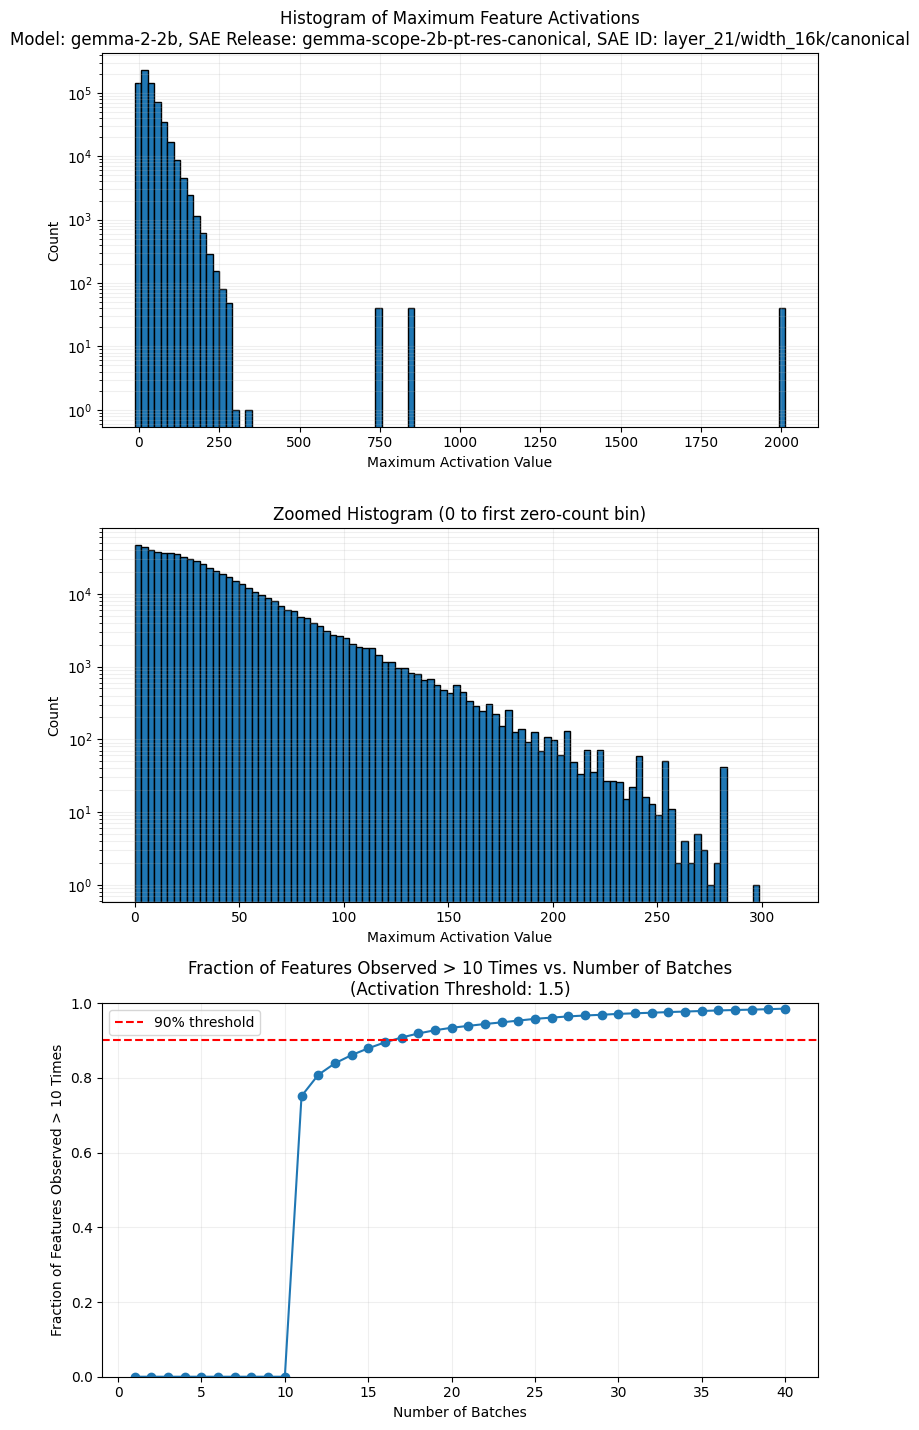

In [9]:
plot_max_activations(
    sae_ids_gemma22b,
    model_name_gemma22b,
    sae_release_short_gemma22b,
    n_batches=40,
    n_bins=100,
    activation_threshold=1.5,
    observation_threshold=10,
    n_batches_in_buffer=gemma_batches,
    remove_special_tokens=False,
    normalise_internal_threshold=True,
    apply_internal_activation_threshold=False,
)

In [ ]:
plot_max_activations(
    sae_ids_gemma22b,
    model_name_gemma22b,
    sae_release_short_gemma22b,
    n_batches=40,
    n_bins=100,
    activation_threshold=1.5,
    observation_threshold=10,
    n_batches_in_buffer=gemma_batches,
    remove_special_tokens=True,
    normalise_internal_threshold=True,
    apply_internal_activation_threshold=False,
)